# Submission 2: Denoising Autoencoders
Trains CNN autoencoders to denoise pneumonia images based on [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf). Contains 3 CNN autoencoders:
1. Autoencoder for denoising noisy images with lambda = 25
2. Autoencoder for denoising noisy images with lambda = 50
3. Autoencoder for denoising noisy images with lambda = 75

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import pandas as pd
from io import StringIO
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from PIL import Image
import torch
from matplotlib import pyplot as plt
from skimage.util import random_noise
import numpy as np

### Load Dataset

In [2]:
original_ds_path = r"datasets/pneumonia"
original_ds_filenames = os.listdir(original_ds_path)

In [3]:
# Dataset of clean (no noise) pneumonia images
class CleanDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_labels = pd.DataFrame([filename for filename in original_ds_filenames])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read image and label/filename
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx]
        return image, label

In [4]:
original_ds = CleanDataset(img_dir=original_ds_path)

In [5]:
# Get indices to split data into 80% training and 20% test data
train_filenames, test_filenames = train_test_split(original_ds_filenames, train_size=0.8, random_state=0)

# Generate training and test sets from indices
train_ds = Subset(original_ds, train_filenames)
test_ds = Subset(original_ds, test_filenames)

print(f"Training samples: {len(train_ds)} ({len(train_ds)/len(original_ds)*100}% of data)")
print(f"Test samples: {len(test_ds)} ({len(test_ds)/len(original_ds)*100}% of data)")

Training samples: 1850 (79.98270644185041% of data)
Test samples: 463 (20.01729355814959% of data)


### Generating Noisy Images

In [6]:
# Dataset of noisy pneumonia images
class NoisyDataset(Dataset):
    def __init__(self, img_dir, filenames, noise_lambda):
        self.img_dir = img_dir
        self.filenames = filenames
        self.noise_lambda = noise_lambda
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()

        noise = np.random.poisson(lam=self.noise_lambda, size=clean_img_tensor.shape).astype(np.float32)
        noisy_img_tensor = clean_img_tensor + torch.from_numpy(noise)

        noisy_img_tensor = torch.clamp(noisy_img_tensor, 0, 255)
        
        return noisy_img_tensor, clean_img_tensor

In [7]:
class NoisyDatasetRGB(Dataset):
    def __init__(self, img_dir, filenames, noise_lambda):
        self.img_dir = img_dir
        self.filenames = filenames
        self.noise_lambda = noise_lambda
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            # transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()

        noise = np.random.poisson(lam=self.noise_lambda, size=clean_img_tensor.shape).astype(np.float32)
        noisy_img_tensor = clean_img_tensor + torch.from_numpy(noise)

        noisy_img_tensor = torch.clamp(noisy_img_tensor, 0, 255)
        
        return noisy_img_tensor, clean_img_tensor

In [8]:
# Create 3 sets of noisy images based on the original dataset
noisy25_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 25)

noisy50_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 50)

noisy75_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 75)

In [9]:
noisy25_dsRGB = NoisyDatasetRGB(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 25)

noisy50_dsRGB = NoisyDatasetRGB(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 50)

noisy75_dsRGB = NoisyDatasetRGB(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 75)

In [10]:
# Create dataloaders
loader = DataLoader(noisy75_ds, batch_size=16)

torch.Size([1, 64, 64])
With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75


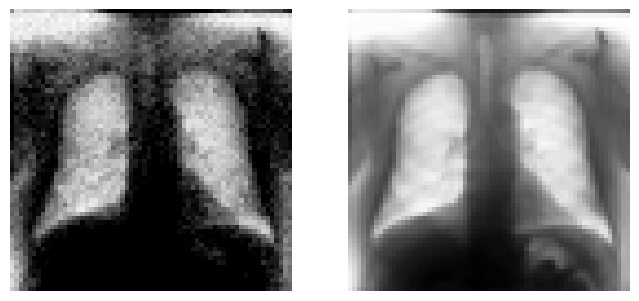

In [11]:
# Display images with and without noise
noisy_imgs, clean_imgs = next(iter(loader))

print(noisy_imgs[0].size())

noisy_img = torch.reshape(noisy_imgs[0], (64, 64, 1))
clean_img = torch.reshape(clean_imgs[0], (64, 64, 1))

imgs = [noisy_img, clean_img]

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(imgs[i-1].squeeze(), cmap="Greys")

print("With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75")
plt.show()

### Training CNN Autoencoders

In [12]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Example for grayscale images, change channels accordingly
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid for [0,1] scaled images
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# Train Model Func
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [14]:
# # Train Model
# from torch.utils.data import DataLoader

# # Example for one set, repeat for each noise level dataset
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.MSELoss()

# model_25 = CNNAutoencoder().to(device)
# optimizer_25 = optim.Adam(model_25.parameters(), lr=0.001)
# dataloader_25 = DataLoader(noisy25_ds, batch_size=64, shuffle=True)

# model_50 = CNNAutoencoder().to(device)
# optimizer_50 = optim.Adam(model_50.parameters(), lr=0.001)
# dataloader_50 = DataLoader(noisy50_ds, batch_size=64, shuffle=True)

# model_75 = CNNAutoencoder().to(device)
# optimizer_75 = optim.Adam(model_75.parameters(), lr=0.001)
# dataloader_75 = DataLoader(noisy75_ds, batch_size=64, shuffle=True)

# # Train each model
# train_model(model_25, dataloader_25, criterion, optimizer_25, num_epochs=25)
# train_model(model_50, dataloader_50, criterion, optimizer_50, num_epochs=25)
# train_model(model_75, dataloader_75, criterion, optimizer_75, num_epochs=25)

## Evaluating results

Evaluate your results against the test images by running the error term you used in submission 1 against each model compared with the 4 other classical methods. The result should be the average error value for each configuration.


In [15]:
# filters from submission 1
import cv2 as cv
import matplotlib.pyplot as pyplot
import numpy as np

img = cv.imread("images/noisy.png")
# pyplot.imshow(img)

# median filter
def median(img):
    kernel_size = 3
    median_filter = cv.medianBlur(img, kernel_size)
    # median_filter = cv.cvtColor(median_filter, cv.COLOR_BGR2GRAY)
    return median_filter
# pyplot.imshow(median_filter)

# mean filter
def mean(img):
    kernel_size = [3, 3]
    mean_filter = cv.blur(img, kernel_size)
    # mean_filter = cv.cvtColor(mean_filter, cv.COLOR_BGR2GRAY)
    return mean_filter
# pyplot.imshow(mean_filter)

# bilateral filter
def bilat(img):
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    size = 15
    sigma_color = 75
    sigma_space = 75
    bilateral_filter = cv.bilateralFilter(img_rgb, size, sigma_color, sigma_space)
    # bilateral_filter = cv.cvtColor(bilateral_filter, cv.COLOR_BGR2GRAY)
    return bilateral_filter
# pyplot.imshow(bilateral_filter)

# gaussian blur filter
def gauss(img):
    kernel_size = [5, 5]
    std_dev = 0 #passing 0 will make function auto compute std dev
    gauss_blur = cv.GaussianBlur(img,kernel_size,std_dev)
    # gauss_blur = cv.cvtColor(gauss_blur, cv.COLOR_BGR2GRAY)
    return gauss_blur
# pyplot.imshow(gauss_blur)



In [16]:
# mean squared error function from submission 1
def mse(img_a, img_b):
    h, w = img_a.shape
    diff = cv.subtract(img_a, img_b)
    err = np.sum(diff**2)
    mse = err/(float(h*w))
    return mse

In [17]:
loader = DataLoader(noisy25_dsRGB, batch_size=16)
noisy_imgs, clean_imgs = next(iter(loader))

noisy_imgs = noisy_imgs.numpy()
clean_imgs = clean_imgs.numpy()

median_score = 0
mean_score = 0
bilat_score = 0
gauss_score = 0
for image_n, image_c in zip(noisy_imgs, clean_imgs):
    img_median = median(image_c)
    img_mean = mean(image_c)
    img_bilat = bilat(image_c)
    img_gauss = gauss(image_c)
    median_eval = mse(image_c, img_median)
    mean_eval = mse(image_c, img_mean)
    bilat_eval = mse(image_c, img_bilat)
    gauss_eval = mse(image_c, img_gauss)
    median_score += median_eval
    mean_score += mean_eval
    bilat_score += bilat_eval
    gauss_score += gauss_eval
median_score = median_score/len(noisy_imgs)
mean_score = mean_score/len(noisy_imgs)
bilat_score = bilat_score/len(noisy_imgs)
gauss_score = gauss_score/len(noisy_imgs)

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 64


In [ ]:
# use mse function

median_eval = mse(img_clear, img_median)
print('MEDIAN eval error: ', median_eval)

mean_eval = mse(img_clear, img_mean)
print('MEAN eval error: ', mean_eval)

bilat_eval = mse(img_clear, img_bilat)
print('BILATERAL eval error: ', bilat_eval)

gauss_eval = mse(img_clear, img_gauss)
print('GAUSSIAN eval error: ', gauss_eval)

# model25


# model50


# model75


**Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.**

The Poisson distribution stands out as the go-to model for simulating noise in medical images due to its close match to the random nature of photon detection, particularly in imaging methods like X-ray and PET scans. It excels in accurately representing situations with low photon counts, which are common in medical imaging, especially when using low radiation doses or capturing areas with minimal tissue density. Moreover, its ability to reflect changes in noise levels according to signal intensity mirrors the real-world behavior seen in medical images. The discrete nature of the Poisson distribution suits the whole number pixel values typical in medical imaging, and it maintains the clarity of edges better compared to the Gaussian distribution. Its solid theoretical grounding in photon counting processes also ensures that the simulated noise aligns well with the statistical properties of actual medical images.

**Which one performed the best? Why do you think this is the case?**

The Bilaterial filter had the best balance between noise reduction and detial preservation. We believe its because it manages to preserve the edge, does selective smoothing, and is very intuitive. It's also very robust.